# Modèle `MVGL`

In [1]:
import numpy as np
import pandas as pd

## Chargements des datasets

In [2]:
datasets = []

### dataset multiple features
https://archive.ics.uci.edu/dataset/72/multiple+features

In [3]:
fourier_view = np.loadtxt("../datasets/multiple+features/mfeat-fou")
f_corr_view = np.loadtxt("../datasets/multiple+features/mfeat-fac")
kar_view = np.loadtxt("../datasets/multiple+features/mfeat-kar")
pix_avg_view = np.loadtxt("../datasets/multiple+features/mfeat-pix")
zer_moment = np.loadtxt("../datasets/multiple+features/mfeat-zer")
morphological_view = np.loadtxt("../datasets/multiple+features/mfeat-mor")

X = [fourier_view.T, f_corr_view.T, kar_view.T,
     pix_avg_view.T, zer_moment.T, morphological_view.T]

dataset_mf = {"X": X, "Y": None}
# paramètres par défaut pour le modèle
dataset_mf["parameters"] = {
    "k": 7,
}
dataset_mf["name"] = "multiple_features"
dataset_mf["can_use_exp"] = False

In [4]:
datasets.append(dataset_mf)

### dataset MSRC-v1

https://github.com/ManshengChen/MCLES

In [5]:
from scipy.io import loadmat

dataset_msrc_v1 = loadmat('../datasets/MSRC-v1.mat')
X = []
for x in dataset_msrc_v1["X"][0]:
    X.append(np.array(x.T, dtype=float))
dataset_msrc_v1 = {"X": X, "Y": np.reshape(dataset_msrc_v1["Y"], (dataset_msrc_v1["Y"].shape[0]))}

# paramètres par défaut pour le modèle
dataset_msrc_v1["parameters"] = {
    "k": 7,
}
dataset_msrc_v1["name"] = "MSRC-v1"
dataset_msrc_v1["can_use_exp"] = True

In [6]:
datasets.append(dataset_msrc_v1)

## Métriques

In [7]:
#> information mutuelle normalisé
from sklearn.metrics import normalized_mutual_info_score

#> exactitude
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

def accuracy_clustering(labels, labels_clusters):
    cm = confusion_matrix(labels, labels_clusters)
    # on trouve l'allocation idéale en resolvant le problème de maximisation transformé en problème de minimisation
    rowCorrect, ColCorrect = linear_sum_assignment(-np.array(cm))
    cm = cm[:,ColCorrect]
    return np.trace(cm) / np.sum(cm)
    
#> pureté
def purity(labels, labels_clusters):
    cm = confusion_matrix(labels, labels_clusters)
    return np.sum(np.max(cm, axis=0)) / np.sum(cm)


In [8]:
def clusteringMeasure(labels, labels_clusters):
    return {
        "ACC" : accuracy_clustering(labels, labels_clusters),
        "NMI" : normalized_mutual_info_score(labels, labels_clusters),
        "PUR" : purity(labels, labels_clusters),
    }
    

## Implémentations et expérimentations

In [9]:
import networkx as nx

In [10]:
# construct graph of similarity

def construct_graph_similarity(A):
    N = A.shape[0]

    # Création du graphe
    graph = nx.Graph()

    # Ajout des nœuds
    graph.add_nodes_from(range(N))

    # Ajout des arêtes
    for i in range(N):
        for j in range(i+1, N):
            if A[i][j] > 0:
                graph.add_edge(i, j, weight=A[i][j])

    return graph


def labels_connected_component(G: nx.Graph):
    labels = np.zeros(G.number_of_nodes())
    k = 0
    for c in sorted(nx.connected_components(G), key=len, reverse=True):
        labels[list(c)] = k
        k = k+1

    return labels


### Code de référence ( écrit en matlab)
https://github.com/kunzhan/MVGL

vous devez installé l'outil opensource `octave`, ainsi que son API d'exécution pour python pour pouvoir exécuter le code matlab.

In [11]:
# installation de octave
!apt install octave

E: Impossible d'ouvrir le fichier verrou /var/lib/dpkg/lock-frontend - open (13: Permission non accordée)
E: Impossible d'obtenir le verrou de dpkg (/var/lib/dpkg/lock-frontend). Avez-vous les droits du superutilisateur ?


In [2]:
# installation de l'API
!pip install oct2py

#### Exécution du modèle sur la dataset  `MSRC-v1`

In [336]:
# test d'utilisation de l'API pour exécuter le code matlab
from oct2py import octave

octave.addpath(octave.genpath('./MVGL-master'))
y = octave.feval("test.m", [2 , 2])
y

y =

   0.50000   0.50000



array([[0.5, 0.5]])

In [365]:
# nombre de clusters
k = 7

# exécution du modèle
Sv, A, P, obj = octave.feval(
    "MVGL.m", dataset_msrc_v1['X'], k)

Sv = Sv[0]
A = A[0]
P = P[0]
obj = obj[0][0]

In [366]:
# attribution des observations aux clusters

labels_clusters = labels_connected_component(
    construct_graph_similarity((A+A.T)/2))

visualisation de la courbe de convergence

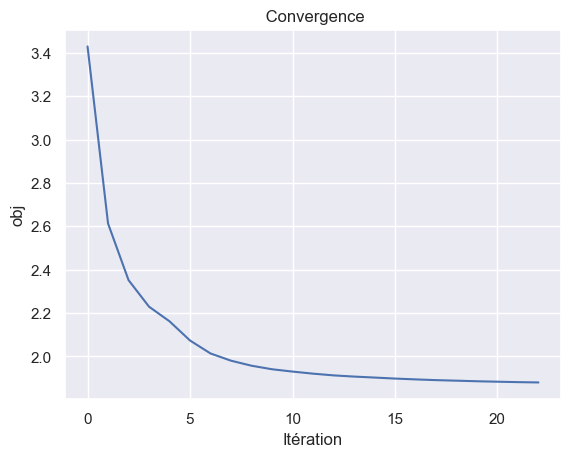

In [367]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt


plt.xlabel('Itération')
plt.ylabel('obj')
plt.title(' Convergence')
plt.plot(obj)

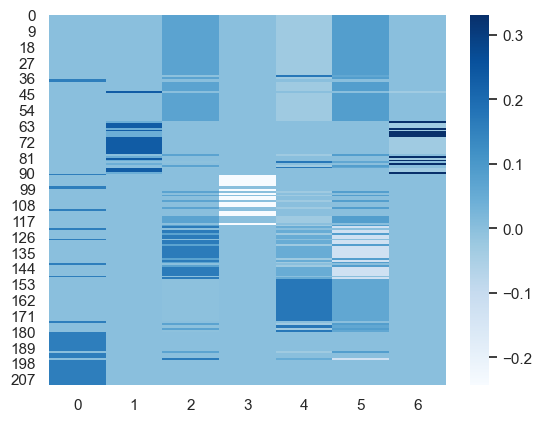

In [368]:
import seaborn as sns; sns.set()
ax = sns.heatmap(P, cmap="Blues")

cacul des métriques

In [369]:
clusteringMeasure(dataset_msrc_v1["Y"], labels_clusters)

{'ACC': 0.6666666666666666,
 'NMI': 0.6336244845986041,
 'PUR': 0.7095238095238096}

#### experimentations sur toutes les datasets

In [16]:
metrics_ref = {"dataset": [], "ACC": [], "NMI": [], "PUR": [], }
for dataset in datasets:
    if dataset["can_use_exp"]:
        print(
            '***** Experimentations sur la dataset {} (en cours)'.format(dataset["name"]))

        # recuperation des paramètres pour le modèle
        k = dataset["parameters"]["k"]

        # execution du modèle en utilisant les paramètres
        _, A, _, _ = octave.feval("MVGL.m", dataset["X"], k)
        A = A[0]

        # construction des clusters
        labels_clusters = labels_connected_component(
            construct_graph_similarity((A+A.T)/2))

        # calcul des métriques
        result = clusteringMeasure(dataset_msrc_v1["Y"], labels_clusters)
        metrics_ref["dataset"] = dataset["name"]
        metrics_ref["ACC"].append(result["ACC"])
        metrics_ref["NMI"].append(result["NMI"])
        metrics_ref["PUR"].append(result["PUR"])
        print("fin\n")


***** Experimentations sur la dataset MSRC-v1 (en cours)
fin



In [17]:
metrics_ref = pd.DataFrame(metrics_ref)
metrics_ref.to_json("metrics_ref.json")
metrics_ref

,dataset,ACC,NMI,PUR
0,MSRC-v1,0.666667,0.633624,0.709524


### modèle `MVGL` en python

#### Implémentaion du modèle

`!!! Pas encore près`

In [349]:
def EProgSimplex_new(b, l=1):
    #
    # Problem
    #
    #  min  1/2 || x - b||^2
    #  s.t. x>=0, 1'x=l
    #
    n = b.shape[0]
    x = b - np.mean(b) + l/n
    if np.min(x) < 0:
        # diff = |1'x - l|
        diff = 1
        lambda_m = 0
        it = 0
        x0 = x
        while  np.abs(diff) > 1e-10:
            x = x0 - lambda_m
            npos = np.sum(x > 0)
            diff = np.sum(x[x > 0]) - l
            lambda_m = lambda_m + diff/npos
            it = it+1
            if it > 100:
                break
        x[x < 0] = 0
    return x


In [350]:
def have_k_components(evs, k, epsilon=1e-11):
    ok = False
    taux = 1

    # somme des k premieres valeurs propres
    evs = np.sort(evs.real)
    sum_propre = np.sum(evs[:k])
    # on a moins de k composents connexes
    if sum_propre > epsilon:
        # on augmente l'importance de l'apprentissage des poids de clusters
        taux = 2

    # on a plus de k composents connexes
    elif sum_propre + evs[k] < epsilon:
        # on diminue l'importance de l'apprentissage des poids de clusters
        taux = 1/2
    else:
        ok = True

    return ok, taux


In [351]:
def updateIndicator(S, k):
    N = S.shape[0]
    Z = (S + S.T) / 2
    D = np.diag(np.sum(Z, axis=1))
    L = D - Z

    eigen_values, eigen_vectors = np.linalg.eig(L)
    idx = np.argsort(eigen_values)
    eigen_values = eigen_values[idx]
    eigen_vectors = eigen_vectors[:, idx]

    return eigen_values, eigen_vectors[:, :k]


In [352]:
def updateSv(P, beta):

    N = P.shape[0]
    gj = np.zeros(N, dtype=float)
    S = np.zeros((N, N))

    for j in range(N):
        for i in range(N):
            gj[i] = np.linalg.norm(P[i] - P[j])**2

        # on recupere les vecteurs booléans qui indique les noeuds
        # à prendre en compte
        # on considère tous les noeuds si handle_only_k_top_neighbour = False
        # idv = [True for _ in range(N)]
        # if handle_only_k_top_neighbour:
        #     for i in np.argsort(gj)[1:(k+1)]:
        #         idv[i] = False

        b = -(gj / 2 / beta)
        S[:, j] = EProgSimplex_new(b)

    return S


In [354]:
def learningSv(X, k, max_iters_S=30):
    # initialisation
    Q = X.T
    N = Q.shape[0]
    S = np.zeros((N, N))
    beta = 1

    for _ in range(max_iters_S):
        # > update S
        S = updateSv(Q, beta)

        # > update Q
        evs, Q = updateIndicator(S, k)

        # > vérification de la convergence
        ok, taux = have_k_components(evs, k)
        if ok:
            break
        else:
            beta = beta / taux

    return S


In [355]:
def learningS(X, k):
    # nombre de vues
    V = len(X)
    # nombre d'observations
    N = X[0].shape[1]

    S = np.zeros((V, N, N))
    for v in range(V):
        S[v] = learningSv(X[v], k)
    return S


In [356]:
def updateA(A0, P, gamma):

    # on vérifie si A0 possède k composantes connexes
    # si oui on retourne A0
    # sinon on calcule A
    # objectif: gagner en temps pour la résolution du problème
    # evs, _ = updateIndicator(A0, k)
    # ok, _ = have_k_components(evs, k)
    # if ok:
    #     return A0

    N = P.shape[0]
    hj = np.zeros(N, dtype=float)
    A = np.zeros((N, N))

    for j in range(N):
        for i in range(N):
            hj[i] = np.linalg.norm(P[i] - P[j])**2

        # on recupere les vecteurs booléans qui indique les noeuds
        # à prendre en compte
        # on considère tous les noeuds si handle_only_neighbour = False
        # idv = [True for _ in range(N)]
        # if handle_only_neighbour:
        #     idv = A0[:, j] > 0

        b = -(gamma * hj/ 2) + A0[:, j]
        A[:, j] = EProgSimplex_new(b)

    return A

In [357]:
def updateW(A, S, eps=2.2204e-16):

    N = A.shape[0]
    V = S.shape[0]

    Zj = np.zeros((N, V))
    W = np.zeros((N, V))
    ones = np.ones(V)

    for j in range(N):

        for v in range(V):
            Zj[:, v] = A[:, j] * S[v, :, j]

        C = np.dot(Zj.T, Zj)
        # regularisation de tikhonov 
        # objectif : éviter que C soit une matrice singulière (non inversible)
        C = C + np.eye(V) * eps * np.trace(C)
        inv = np.linalg.inv(C)
        # W[j] = np.dot(inv, ones) / np.dot(ones, np.dot(inv, ones))
        inv = np.dot(inv, ones)
        W[j] = inv / np.dot(ones, inv)

    return W


In [359]:
def learningA(S, k, max_iters=30, epsilon=1e-3):
    V = S.shape[0]
    N = S.shape[1]

    # initialisation
    W = np.ones((N, V))/V
    A = np.zeros((N, N))
    for j in range(N):
        for v in range(V):
            A[:, j] += W[j, v] * S[v, :, j]
    _, P = updateIndicator(A, k)
    A0 = A

    obj_old = 1
    obj = 10
    objectives = []
    it = 0
    while abs((obj - obj_old)/obj_old) > epsilon:
        it = it + 1

        gamma = 1
        for _ in range(max_iters):
            # > update A
            A = updateA(A0, P, gamma)

            # > update P
            Q = P
            evs, P = updateIndicator(A, k)

            # > verification de la convergence
            ok, taux = have_k_components(evs, k)

            if ok:
                break
            else:
                gamma = gamma * taux
                if taux < 0:
                    P = Q

        # > update W
        W = updateW(A, S)

        # calcul de la fonction objective
        obj_old = obj
        for j in range(N):
            A0[:, j] = 0
            for v in range(V):
                A0[:, j] += W[j, v] * S[v, :, j]
        obj = np.sum((A-A0)**2)
        # np.trace(np.dot(np.dot(P.T, L), P)) = 0 car on a déja k composantes connexes)
        objectives.append(obj)

        print(obj)

    return objectives, A


In [361]:
def MVGL(X, k, beta=1, lambda_=1, epsilon=1e-3):

    # > appretissage des graphes de similarité pour chacune des vues
    S = learningS(X, k)

    # > fusion des graphes de similarités
    objectives, A = learningA(S, k, epsilon=epsilon)
    G = construct_graph_similarity((A+A.T)/2)

    # > calcul des labels de composantes connexes
    labels = labels_connected_component(G)

    _, P = updateIndicator(A, k)
    return {"A": A, "P": P.real, "obj": objectives, "labels": labels}


In [ ]:
# nombre de clusters
k = 7

# exécution du modèle
result = MVGL(dataset_msrc_v1['X'], k)

In [ ]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt


plt.xlabel('Itération')
plt.ylabel('obj')
plt.title(' Convergence')
plt.plot(result["obj"])